# Naive Bayes and KNN using scikit-learn

Note: The dataset used here is the same diabetic retinopathy set [here](http://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set).

In [4]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
%matplotlib inline

In [6]:
# Read the data from csv file
col_names = []
for i in range(20):
    if i == 0:
        col_names.append('quality')
    if i == 1:
        col_names.append('prescreen')
    if i >= 2 and i <= 7:
        col_names.append('ma' + str(i))
    if i >= 8 and i <= 15:
        col_names.append('exudate' + str(i))
    if i == 16:
        col_names.append('euDist')
    if i == 17:
        col_names.append('diameter')
    if i == 18:
        col_names.append('amfm_class')
    if i == 19:
        col_names.append('label')

data = pd.read_csv("messidor_features.txt", names = col_names)
print(data.shape)
data.head(10)
classLabel = data.pop("label")

(1151, 20)


## Part 1: Naive Bayes Classifier

The code below uses a naive bayes classifier within a 10-fold cross validation algorithm. Accuracy here is presented as an average of the results of the CV.

In [7]:
naiveBayesClassifier = GaussianNB(priors=None)
NBCrossVal = cross_val_score(naiveBayesClassifier,data,classLabel,cv=10)
print("Accuracy: "+str(NBCrossVal.mean()))

Accuracy: 0.5977286356821588


`cross_val_predict` will return the predictions for every record when it was within the test set using the model. The first printed `NBMatrix` object will be a confusion matrix for these predictions, with the layout as follows for the array indexes: 
* (0,0) = true negatives (value of 501)
* (0,1) = false positives (value of 39)
* (1,0) = true positives (value of 420)
* (1,1) = false negatives (value of 191)

Below this matrix is a table of error measures for the predictions from the classifier based on this matrix, with the rows (0 or 1) being doesn't have retinopathy and does have retinopathy respectively.

In [8]:
pred = cross_val_predict(naiveBayesClassifier,data,classLabel)
NBMatrix = confusion_matrix(classLabel,pred)
print(NBMatrix)
classRep = classification_report(classLabel,pred)
print(classRep)

[[501  39]
 [420 191]]
              precision    recall  f1-score   support

           0       0.54      0.93      0.69       540
           1       0.83      0.31      0.45       611

    accuracy                           0.60      1151
   macro avg       0.69      0.62      0.57      1151
weighted avg       0.70      0.60      0.56      1151



Below is an implementation of a ROC (Reciever Operating Characteristic) curve for the predictions made by the NB classifier to get good info on the specificity vs sensitivity tradeoff.

Note:
* FPR = false positive rate
* TPR = true positive rate

Area under the curve: 0.6649080494422672


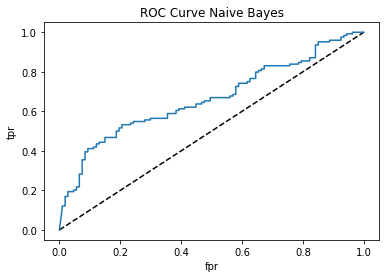

In [9]:
trainData, testData, trainLabels, testLabels =train_test_split(data, classLabel, test_size=0.2, train_size=0.8)
# training set data is at 0 index of array and test data is at 1 index of array
naiveBayesClassifier.fit(trainData, trainLabels)
probArray = naiveBayesClassifier.predict_proba(testData)
newROC = roc_curve(testLabels,probArray[:,1])
fpr, tpr = newROC[0], newROC[1]
print("Area under the curve: "+str(roc_auc_score(testLabels,probArray[:,1])))

plt.plot([0,1],[0,1],'k--') #plot the diagonal line
plt.plot(fpr, tpr, label='NB') #plot the ROC curve
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve Naive Bayes')
plt.show()

## Part 2: K Nearest Neighbor (KNN) Classifier

The dataset will be normalized (between 0 and 1) in order to use a KNN classifier, this is necessary because the usage of distance (usually Euclidean) between points with KNN classifiers leads to class imbalances if normalization is NOT used. `MinMaxScaler` is used to achieve this.

In [10]:
scaler = MinMaxScaler()
scaler.fit(data)
scaledData = scaler.transform(data)
scaledData

array([[1.        , 1.        , 0.14      , ..., 0.53080127, 0.26113347,
        1.        ],
       [1.        , 1.        , 0.15333333, ..., 0.68230157, 0.5363407 ,
        0.        ],
       [1.        , 1.        , 0.40666667, ..., 0.72683611, 0.43797313,
        0.        ],
       ...,
       [1.        , 0.        , 0.32      , ..., 0.85928137, 0.446002  ,
        0.        ],
       [1.        , 1.        , 0.25333333, ..., 0.52665345, 0.30245578,
        1.        ],
       [1.        , 1.        , 0.04      , ..., 0.83950012, 0.192513  ,
        0.        ]])

A `k = 5` classifier will be used within a 10-fold CV and some error measures will be printed in order to get an idea of the effectiveness of this classifier

In [11]:
KNN = KNeighborsClassifier()
KNN.fit(scaledData, classLabel)
KNNpred = cross_val_predict(KNN,scaledData,classLabel, cv=10)
print(classification_report(classLabel,KNNpred))

              precision    recall  f1-score   support

           0       0.60      0.65      0.62       540
           1       0.67      0.62      0.64       611

    accuracy                           0.64      1151
   macro avg       0.64      0.64      0.63      1151
weighted avg       0.64      0.64      0.64      1151



We will tune hyperparameters for `k` using grid search below:

In [13]:
grid_params = {'n_neighbors': range(1, 31)}
optimalk = GridSearchCV(KNN, grid_params, cv=10, scoring='accuracy')
optimalk.fit(scaledData,classLabel)
print("Best Value of k: ", str(optimalk.best_params_['n_neighbors']))
print(optimalk.best_params_)

Best Value of k:  23
{'n_neighbors': 23}


Below are the new error measures for the new `k = 23` classifier. Note the improvement (albeit small) over the previous placeholder value of 5.

In [14]:
newKNN = KNeighborsClassifier(n_neighbors = 23)
newKNN.fit(scaledData,classLabel)
newKNNpred = cross_val_predict(newKNN,scaledData,classLabel, cv = 10)
print(classification_report(classLabel,newKNNpred))

              precision    recall  f1-score   support

           0       0.62      0.72      0.67       540
           1       0.71      0.61      0.65       611

    accuracy                           0.66      1151
   macro avg       0.66      0.66      0.66      1151
weighted avg       0.67      0.66      0.66      1151



Below, a nested 10 fold cross validation is used with our prior grid search object. This will prevent overfitting, and will give us a good idea of the generalization error of our model. The arrays+measures printed below are in the following order of scoring categories:
* Accuracy
* Recall
* Precision

In [34]:
#yaga = cross_val_predict(optimalk, scaledData, classLabel, cv = 10)
yaga = cross_val_score(optimalk, scaledData, classLabel, cv = 10)
yaga2 = cross_val_score(optimalk, scaledData, classLabel, cv = 10, scoring='recall')
yaga3 = cross_val_score(optimalk, scaledData, classLabel, cv = 10, scoring='precision')

#print(classification_report(classLabel,yaga))
# accuracy
print(yaga)
print(yaga.mean())

# recall
print(yaga2)
print(yaga2.mean())

#precision
print(yaga3)
print(yaga3.mean())

[0.6637931  0.66956522 0.72173913 0.62608696 0.65217391 0.72173913
 0.5826087  0.65217391 0.6173913  0.64347826]
0.6550749625187406
[0.58064516 0.63934426 0.72131148 0.50819672 0.55737705 0.70491803
 0.47540984 0.52459016 0.60655738 0.52459016]
0.5842940243257535
[0.73469388 0.70909091 0.74576271 0.70454545 0.72340426 0.75438596
 0.64444444 0.74418605 0.64912281 0.72727273]
0.7136909198529564


Below, the code is using a PCA transformation on the data within a cross validation. However, the difference is that a pipeline must be used in order to apply this properly. The code as set up will first apply the PCA to the training data, and THEN the test data will be transformed into that space. The KNN classifier will be applied right after the PCA within the folds on both the train AND the test data. This is all done in order to avoid the curse of dimensionality (which can also be done with feature engineering/selection).

In [29]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA()
knn = KNeighborsClassifier()
pipe = Pipeline(steps=[('pca', pca), ('knn', knn)])

#Parameters of pipelines are set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': list(range(1, 19)),
    'knn__n_neighbors': list(range(1, 30)),
}
#Pipeline is passed into the GridSearchCV below for 5-fold 
gridz = GridSearchCV(pipe, param_grid=param_grid, scoring="accuracy", cv = 5)
gridz.fit(scaledData,classLabel)
print(gridz.best_params_)
print(gridz.best_score_)

{'knn__n_neighbors': 23, 'pca__n_components': 13}
0.6603124411820064


As can be seen above, we are left with an accuracy of ~66% which can be significantly improved upon but is nearly 10% better than when we started with only a few basic tweaks.